In [1]:
import yt
import numpy as np

N = 8

data = {"density": np.random.random((N, N, N))}

cell_widths = []
for i in range(3):
    _ = np.random.random(N)
    _ /= _.sum()
    cell_widths.append(_)

ds = yt.load_uniform_grid(
    data,
    [N, N, N],
    bbox=np.array([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]),
    cell_widths=cell_widths,
)

yt : [INFO     ] 2022-09-12 15:44:24,624 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-09-12 15:44:24,625 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2022-09-12 15:44:24,626 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2022-09-12 15:44:24,626 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2022-09-12 15:44:24,627 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2022-09-12 15:44:31,114 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 15:44:31,114 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 15:44:31,115 xlim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 15:44:31,115 ylim = 0.000000 1.000000
yt : [INFO     ] 2022-09-12 15:44:31,118 Making a fixed resolution buffer of (('stream', 'density')) 800 by 800



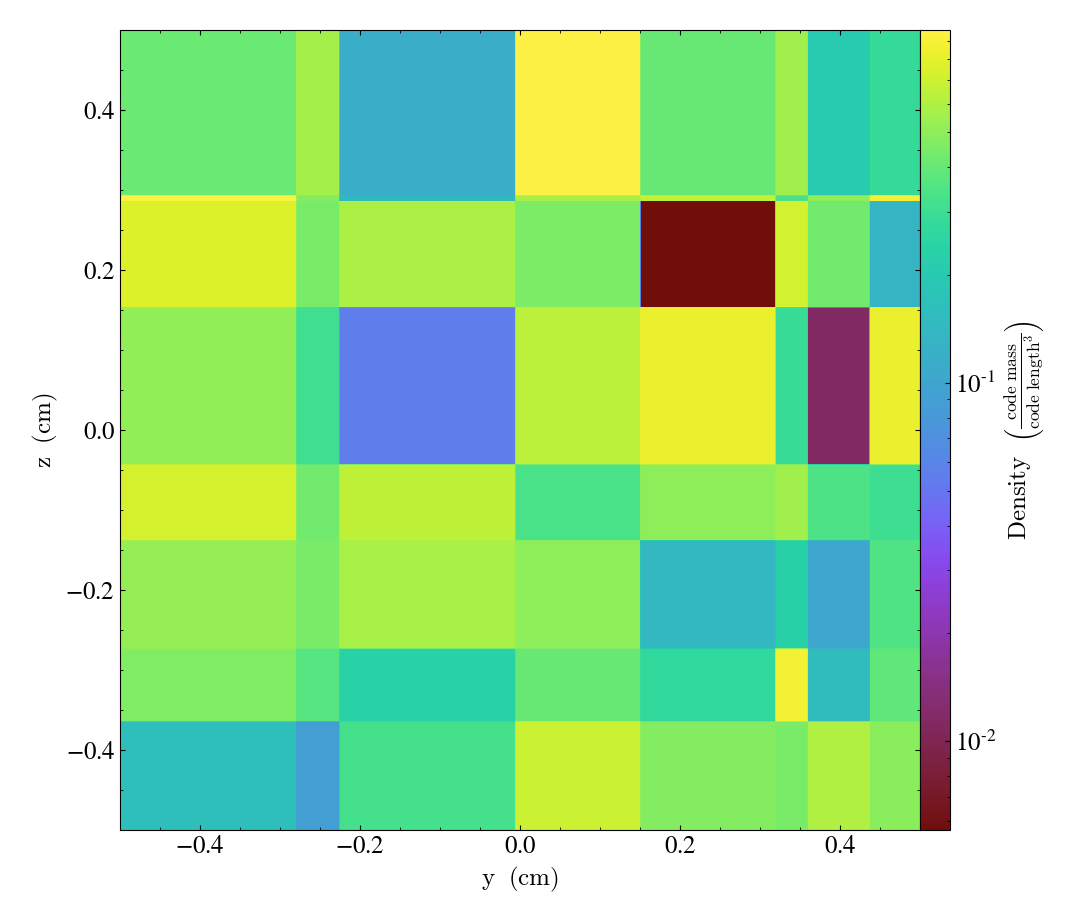

In [2]:
yt.SlicePlot(ds, 'x', ("stream", "density"))

Text(0, 0.5, 'cell center [km]')

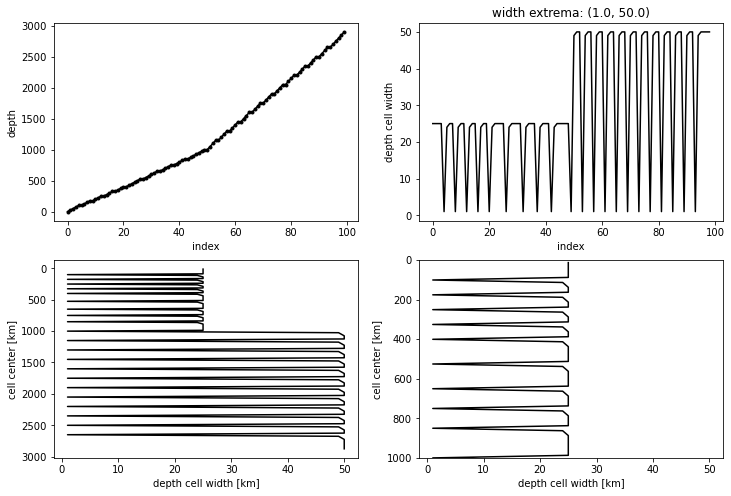

In [4]:
import xarray as xr
import os 
import matplotlib.pyplot as plt 

ddir = os.path.join(yt.config.ytcfg.get('yt','test_data_dir'), 'sample_nc')
datasets = {
    "internal_geographic_partial": os.path.join(ddir,'wUS-SH-2010_percent.nc'), 
    "internal_geographic_global": os.path.join(ddir,'GYPSUM_percent.nc'), 
}

ds = xr.open_dataset(os.path.join(ddir, datasets["internal_geographic_global"]))
dvs = ds.dvs
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(dvs.coords['depth'],'k')
plt.plot(dvs.coords['depth'],'.k')
plt.ylabel("depth")
plt.xlabel("index")

plt.subplot(2,2,2)
dp = dvs.coords['depth'].to_numpy()
wids = dp[1:] - dp[0:-1]
plt.plot(wids,'k')
plt.ylabel("depth cell width")
plt.title(f"width extrema: ({wids.min()}, {wids.max()})")
plt.xlabel("index")

plt.subplot(2,2,3)
centers = (dp[1:] + dp[0:-1])/2
plt.plot(wids, centers, 'k')
plt.gca().invert_yaxis()
plt.xlabel("depth cell width [km]")
plt.ylabel("cell center [km]")

plt.subplot(2,2,4)
plt.plot(wids, centers, 'k')
plt.ylim([0, 1000])
plt.gca().invert_yaxis()
plt.xlabel("depth cell width [km]")
plt.ylabel("cell center [km]")


In [5]:
import xarray as xr
import yt
import os
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs

ddir = os.path.join(yt.config.ytcfg.get('yt','test_data_dir'), 'sample_nc')
      

# https://ds.iris.edu/files/products/emc/emc-files/GYPSUM_percent.nc : a global model
# https://ds.iris.edu/files/products/emc/emc-files/wUS-SH-2010_percent.nc : a non-global model covering the western US


datasets = {
    "internal_geographic_partial": os.path.join(ddir,'wUS-SH-2010_percent.nc'), 
    "internal_geographic_global": os.path.join(ddir,'GYPSUM_percent.nc'), 
}


def get_widths(x):
    # calculates the cell width from an array of observation points, preserving
    # the min/max of the ranges. 
    extrema = [x.min(), x.max()]
    
    # calculate edges of cells, preserving data min/max.
    edges = (x[1:] +x[0:-1])/2
    edges = np.concatenate([np.array([extrema[0]]), edges, np.array([extrema[1]])])                        
    wids = edges[1:] - edges[0:-1]
    return wids.astype(np.float64), extrema
    
def get_internal_IRIS(case):
    # both datasets have the same variables and dimension order
    
    fi = datasets[case]
     
    with xr.open_dataset(fi) as xr_ds:
        dvs = xr_ds.dvs.to_masked_array().data
        
        fake_data = np.ones(dvs.shape)
        for idep in range(1,dvs.shape[0]):
            fake_data[idep, :, :] = -1 * fake_data[idep-1, :, :]
            
            
        depth_wids, deprng = get_widths(xr_ds.depth.data)
        lon_wids, lonrng = get_widths(xr_ds.longitude.data)
        lat_wids, latrng = get_widths(xr_ds.latitude.data)
        

    data = {'dvs': (dvs, "%"),
            'flipping_ones': (fake_data, "")}
    
    bbox = np.array([
      deprng,   
      latrng,
      lonrng
    ])
    
    cell_wids = [depth_wids, lat_wids, lon_wids]

    dims = ['depth', 'latitude', 'longitude']

    return yt.load_uniform_grid(data, data['dvs'][0].shape, 1.0, 
                                geometry=("internal_geographic", dims),
                                bbox=bbox, 
                                cell_widths=cell_wids)



In [6]:
ds = get_internal_IRIS('internal_geographic_global')


yt : [INFO     ] 2022-09-12 15:45:44,051 Parameters: current_time              = 0.0
yt : [INFO     ] 2022-09-12 15:45:44,051 Parameters: domain_dimensions         = [100 181 361]
yt : [INFO     ] 2022-09-12 15:45:44,052 Parameters: domain_left_edge          = [   0.  -90. -180.]
yt : [INFO     ] 2022-09-12 15:45:44,053 Parameters: domain_right_edge         = [2900.   90.  180.]
yt : [INFO     ] 2022-09-12 15:45:44,053 Parameters: cosmological_simulation   = 0


In [7]:
ds.index

yt : [INFO     ] 2022-09-12 15:46:00,520 xlim = 0.000000 2900.000000
yt : [INFO     ] 2022-09-12 15:46:00,521 ylim = -2900.000000 2900.000000
yt : [INFO     ] 2022-09-12 15:46:00,521 Setting origin='native' for internal_geographic geometry.
yt : [INFO     ] 2022-09-12 15:46:00,522 xlim = 0.000000 2900.000000
yt : [INFO     ] 2022-09-12 15:46:00,523 ylim = -2900.000000 2900.000000
yt : [INFO     ] 2022-09-12 15:46:00,524 Making a fixed resolution buffer of (('stream', 'flipping_ones')) 1000 by 1000



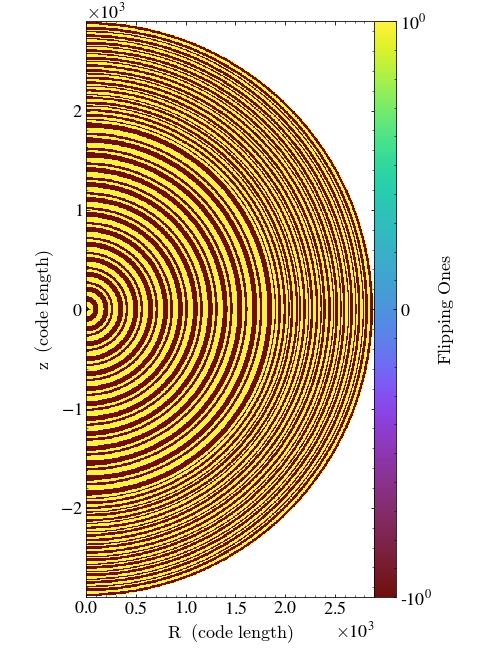

In [8]:
slc = yt.SlicePlot(ds, 'longitude', ('stream', 'flipping_ones'), buff_size=(1000,1000))
slc.show()